In [137]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic,KNNWithMeans,KNNBaseline

In [138]:
dt = pd.read_csv('/Users/youyang/Downloads/ratings_Grocery_and_Gourmet_Food.csv')

In [139]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297155 entries, 0 to 1297154
Data columns (total 4 columns):
A1ZQZ8RJS1XVTX    1297155 non-null object
0657745316        1297155 non-null object
5.0               1297155 non-null float64
1381449600        1297155 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.6+ MB


In [140]:
dt.head()


,A1ZQZ8RJS1XVTX,0657745316,5.0,1381449600
0,A31W38VGZAUUM4,0700026444,5.0,1354752000
1,A3I0AV0UJX5OH0,1403796890,1.0,1385942400
2,A3QAAOLIXKV383,1403796890,3.0,1307836800
3,AB1A5EGHHVA9M,141278509X,5.0,1332547200
4,A3DTB6RVENLQ9Q,1453060375,1.0,1362268800


In [141]:
dt.columns = ['reviewerID','productID','rating','unixTime']

In [142]:
dt['unixTime'] = pd.to_datetime(dt['unixTime'],unit='s')
dt = dt.rename(columns={'unixTime':'date'})
#Only take recent reviews
dt = dt.loc[dt['date']>'2014-01-01']
#Last Date
dt['date'].max()

Timestamp('2014-07-23 00:00:00')

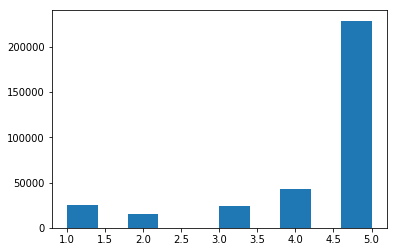

In [143]:
#Histogram of ratings
rating_hist = plt.hist(dt['rating'],align='mid')
#Group by product ID to count reviews per product
item_groupby = dt.groupby('productID',as_index=False)
review_count = item_groupby['reviewerID'].count()
review_count.columns = ['productID','count_review']

In [144]:
review_count.head()

,productID,count_review
0,1603112251,1
1,1613170416,3
2,1837994021,1
3,3295000018,13
4,3301261876,6


In [145]:
#Randomly select products from subset of products with at least a number of reviews
review_number = 10
product_sample_number = 100
product_list = review_count[review_count['count_review']>=review_number]
random_product = product_list.take(np.random.permutation(len(product_list))[:item_sample_number])
random_product_list = random_product['productID']

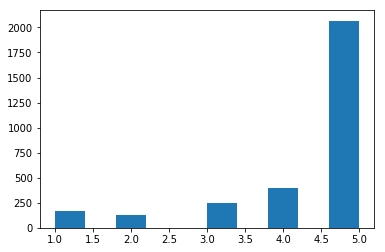

In [146]:
#Merge these products with original rating data
data = dt.loc[dt['productID'].isin(random_product_list)].reset_index(drop=True)
rating_hist = plt.hist(data['rating'],align='mid')
#Write to a CSV file
data.to_csv('/Users/youyang/PycharmProjects/jupyter/personalization/sample_data')

In [147]:
data.head
data.describe

<bound method NDFrame.describe of           reviewerID   productID  rating       date
0     A1INMC17071ZZB  B0000CETGM     3.0 2014-03-31
1     A38VT93S2LZDPZ  B0000CETGM     1.0 2014-06-01
2      AWMPZ75QF3V0Y  B0000CETGM     1.0 2014-05-08
3      ADC2Z0AB8X7GF  B0000CETGM     4.0 2014-05-07
4      ABU7ZR51MY2RL  B0000CETGM     5.0 2014-05-21
5     A3BOO9OVZ550WI  B0000CETGM     5.0 2014-07-12
6     A1LIR6NXC9Y9AD  B0000CETGM     3.0 2014-01-14
7     A2L0UI546N5ORD  B0000CETGM     1.0 2014-02-09
8     A2GSJAWU4T8TUK  B0000CETGM     5.0 2014-02-03
9     A2Z45C98G5HNVB  B0000CETGM     1.0 2014-02-04
10     A18CTJ0LVUB2X  B0000CETGM     5.0 2014-01-14
11     AIOX05ISAA25K  B0000CETGM     5.0 2014-06-28
12    A373JYHXFGG67S  B0000CETGM     5.0 2014-01-21
13    A3TAN35YVDC9GL  B0000CETGM     5.0 2014-01-11
14    A2DEWYECHHHEW0  B0000CETGM     5.0 2014-04-05
15     AFXDGS9DSYIPY  B00016XJM4     2.0 2014-01-07
16    A3FVX9CNKD4WPB  B00016XJM4     4.0 2014-01-18
17    A2NIOWK7LXBOFK  B00016XJ

# K-NN

In [148]:
# load data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['reviewerID','productID','rating']],reader)

In [155]:

## 
folds_number = 5
same_dataset = True

## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
train_sim_option={'name': 'msd', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 40 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

## define evaluate setting
measure_way = ['RMSE', 'MAE'] ## fcp
verbose = 2

In [156]:
data.split(n_folds=folds_number, shuffle= same_dataset)
algo = algo_name(k = max_k, min_k = min_k, sim_options=train_sim_option)

In [157]:
perf = evaluate(algo, data, measures=measure_way, verbose= verbose)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
user: A2E6UU9A6XLSK5 item: B0046HFHD8 r_ui = 4.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A1609AHFQCHGW6 item: B008RJMXPQ r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3CMYD5REF7GBD item: B001FVNM3A r_ui = 2.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A106P5O3BJXVAE item: B008GE90AS r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A37NBFMD3HQGY3 item: B004391DK0 r_ui = 3.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A11V6WFPYUV73F item: B000EVG8FQ r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3OE8046KWT42B item: B00HBBYWNW r_ui = 1.00   est = 4.36   {'was_impos

user: ARJOESC9F8LFF item: B00CADA3AM r_ui = 3.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2LASORRVJQI66 item: B0014EOU9S r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3NHZR8IQ92VE9 item: B00C1W77W4 r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A12283BMAQF2IC item: B00HHYQUUG r_ui = 2.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: AHL3KOFMYUCCN item: B007OWP35Y r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A1K4I48O7J7E5E item: B00IOTRS5E r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: ANUA6MDPUW178 item: B008RJMXPQ r_ui = 5.00   est = 4.36   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A1UIX3JO861ZFV item: B007919G8U r_ui = 5.00   est = 4.36   {'was_impossible': Tr

Done computing similarity matrix.
user: A2NX6GCH98TRRM item: B00473X4BS r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A353UQ06Z3PIFC item: B001VNGNEM r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2RJVR2JTBOKWD item: B0095XLRKU r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: ACUWEQJR06ABC item: B00HHYQUUG r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2NIJTYWADLK57 item: B004391DK0 r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A288D2R9WAJBZS item: B000R4LONQ r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2NBQ9E181AC8O item: B0052HV6EU r_ui = 3.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A1OIYDXNL0SMTT item: B006OG0B9Y r_ui = 1.00 

Done computing similarity matrix.
user: A198B526NNTIAA item: B007919G8U r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: AVUVEIKPA500K item: B003GV7JFE r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2V47EH7PCNDAB item: B003LPKERK r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A16MC7SVPG7A8M item: B008RJMXPQ r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A19KSVLE1Z0MND item: B008GE90AS r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A1ANV6HNVHZWVQ item: B004391DK0 r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3EW5JQNFM2HA4 item: B00C1W77W4 r_ui = 4.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3YWPZ71CBDSV item: B001M09BUW r_ui = 3.00  

user: A28ZXOUUW42350 item: B004UB6HHU r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: AUL5P9UO1BL8E item: B0014EOU9S r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A20OENJ2DLGX0W item: B0017I753O r_ui = 4.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A6EEC1OPIINWC item: B002UGMH9Y r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A7F1LY87CGM79 item: B006IOKA9S r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: AN3BXZ2AZ28ED item: B006IOKA9S r_ui = 5.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2J39ZAFGP734L item: B003XB3NNE r_ui = 4.00   est = 4.35   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3KXKOK77BJRLD item: B006IOKA9S r_ui = 5.00   est = 4.35   {'was_impossible': Tru

user: A2W0XCWOK3MW6F item: B00HBBYWNW r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3FVX9CNKD4WPB item: B00016XJM4 r_ui = 4.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2S77DN7EF3X2P item: B006IOKA9S r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2X2JPK4M6JVT item: B008RJMXPQ r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: AUUY8GDDZCESY item: B000R4LONQ r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A107Y0NMKQJW95 item: B005H8YMYU r_ui = 2.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A2F0BUVLB7ZD0F item: B000FNM5PU r_ui = 5.00   est = 4.34   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}
user: A3GIR16ZC8JC5P item: B00C70CHWA r_ui = 5.00   est = 4.34   {'was_impossible': T

In [152]:

## have a deep look

for trainset, testset in data.folds():
    # train and test algorithm.
    algo.train(trainset)
    predictions = algo.test(testset)
    print("{test},{pred}".format(test = testset,pred=predictions))
    

Computing the msd similarity matrix...
Done computing similarity matrix.
[('A2Y0BRZZDCSIIU', 'B00C1W77W4', 5.0), ('A2JIBR2ECYLF8H', 'B005LURCGO', 1.0), ('A1OZ0899LWXHV0', 'B001F3LC80', 5.0), ('A3M1TVH7XNXNV7', 'B0017I753O', 5.0), ('A2VZJC2X3KEBUT', 'B001SAQDYS', 2.0), ('A1FSR1HSO8P5E3', 'B001L7X1HA', 2.0), ('A3BMJUPINFSNDN', 'B00A2A58SM', 4.0), ('A2Z0QZR6T39TW', 'B009DQBQ5U', 5.0), ('A3KNZ0DD8OK29F', 'B004TNVSDW', 5.0), ('A7WH560VVUXB2', 'B00HBBYWNW', 4.0), ('ANMK1EC84WDOY', 'B00C70CHWA', 5.0), ('A10V4G6JCRPMTF', 'B0099XPG94', 5.0), ('A1VB9EZ08BOW3J', 'B000SATIQO', 5.0), ('A1HVJMW4WKT6JW', 'B00CADA3AM', 5.0), ('A1QT5LMPJ5Y25P', 'B00D50ENB4', 5.0), ('A2N2ON7OYC862X', 'B00IOTRS5E', 1.0), ('A3MSB96N5TYC2B', 'B008RJMXPQ', 5.0), ('A3KO6JEVS1FJ8X', 'B006IOKA9S', 4.0), ('A9TCBI8KIFJ0M', 'B00C1W77W4', 3.0), ('A2YKWYC3WQJX5J', 'B00HBBYWNW', 4.0), ('A1WEINLM2ZMJHU', 'B0095XLRKU', 1.0), ('A2G0X17OH21HYM', 'B0052XRMJ2', 1.0), ('A19QYX5Z7ZFFZQ', 'B004391DK0', 2.0), ('A30CSYNRPPIGPV', 'B001M09BUW', 

Done computing similarity matrix.
[('AXTXPKWPLDQ3P', 'B003XUL1VQ', 5.0), ('A2KY8KQTR9AJTQ', 'B003EJ9KLO', 5.0), ('A1D0F8HAZ66ZPY', 'B008RJMXPQ', 4.0), ('A1H97ARND31P08', 'B000R4LONQ', 5.0), ('ADCY0I8EGWCGO', 'B006IOKA9S', 5.0), ('A2OA83PN1TPAML', 'B008RJMXPQ', 5.0), ('ANJPYG39PNKZS', 'B003YVTF30', 5.0), ('A21NYNC8D6R9BW', 'B0052XRMJ2', 1.0), ('A2NX6GCH98TRRM', 'B00473X4BS', 5.0), ('A1COKKFI7SJ3S4', 'B00C1W77W4', 3.0), ('A2B779DX1W1IP3', 'B003EJ9KLO', 5.0), ('AGJGJWK3BOHE1', 'B004TJD72Q', 5.0), ('A3K4645OMPCV2M', 'B004UKHISI', 5.0), ('A1402SAFXKYXVE', 'B004391DK0', 5.0), ('A3KEEI906FKJCY', 'B008RJMXPQ', 5.0), ('A2DRT7RZTMNJ88', 'B002RTK5L6', 5.0), ('AMFNPKWGX9K99', 'B00HHYQUUG', 2.0), ('A1L57ZMWHDAM96', 'B0096S6OX4', 5.0), ('A3CKSAJLKA8Q1Q', 'B000HDOQ5U', 5.0), ('A1S86FK5KFNMQA', 'B001710KV0', 5.0), ('A2QHMZ6KS29TB7', 'B003EJ9KLO', 5.0), ('A1OPPKUKMTXX6E', 'B0093JX9RA', 5.0), ('A107T37V4DJW8B', 'B003TI5CL2', 5.0), ('AWIL17SPLV7CQ', 'B000HTDFCE', 5.0), ('A3D7LVKXGL86OZ', 'B00DGWTIC0', 5.

Done computing similarity matrix.
[('A1PEJ8XOBDMELT', 'B00HHYQUUG', 5.0), ('AS44QEHT3KSPK', 'B00HBBYWNW', 1.0), ('A1PS7X0DLOWV8', 'B000EVG8FQ', 5.0), ('A2F9JH9NQAE903', 'B006Z9VPXQ', 5.0), ('AWKY7HZOJEHJI', 'B004UKHISI', 5.0), ('A39R25NCLXV0RH', 'B003GV7JFE', 5.0), ('A1HKHLRU9EI5QT', 'B008OUN6JK', 4.0), ('A3DD9GB3QFCH27', 'B00016XJM4', 5.0), ('A2JM6XP6A7CHOB', 'B003YVTF30', 4.0), ('A3HDSV96K0DD56', 'B003GV7JFE', 1.0), ('A1C46HN7U2D3DM', 'B003EJ9KLO', 5.0), ('A1OQ00TSHPZYLW', 'B00A2A58SM', 2.0), ('A1ELA3HWOQWBPO', 'B000E671XY', 5.0), ('A1D30IDRY41P4U', 'B00A49LOV6', 5.0), ('A29L2S725GBWZB', 'B00IOTRS5E', 5.0), ('A2VANAQKK9VIFE', 'B003Q4TTUO', 5.0), ('A2ZWPLINHIK3DS', 'B0099XPG94', 5.0), ('A2XKJ1KX6XUHYP', 'B004VLVIGE', 5.0), ('A112EUVCGGY8UG', 'B003KYIY6U', 5.0), ('A2264HYWIV1PB1', 'B004UKHISI', 1.0), ('A13PN0VFMXDSHS', 'B006OG0B9Y', 2.0), ('A2KZUPVVOHXWLW', 'B004391DK0', 5.0), ('A2BZRXM5522HBT', 'B00IOTRS5E', 3.0), ('A3GTU3AY1YLLMS', 'B00HBBYWNW', 3.0), ('A3BNYC25EOEURJ', 'B001SAQDYS',

Done computing similarity matrix.
[('A38303UBHPABH4', 'B003EJ9KLO', 4.0), ('A1SORZL733985Z', 'B00HBBYWNW', 2.0), ('A1DEIUI4NBPTA1', 'B004391DK0', 4.0), ('A2J5V4UEC68FH5', 'B001F3LC80', 3.0), ('A2UV5XTF62RA6P', 'B00HHYQUUG', 5.0), ('A1017Q5HHWNALE', 'B00DGWTIC0', 5.0), ('A4L0UD2AWHART', 'B006IOKA9S', 5.0), ('ARLUTXRPIN1VM', 'B004JM95YC', 5.0), ('A1G8XHIDW5Y2X2', 'B006OG0B9Y', 5.0), ('A17DSU4RDX0RN7', 'B00CADA3AM', 4.0), ('A3DEL7R9WYJ40H', 'B00D50ENB4', 5.0), ('A38TPMVTFZ9SHH', 'B000LKZI60', 5.0), ('A2OGZT0ZXWKF8Q', 'B0017I753O', 5.0), ('A1KAPFPTIFF7K7', 'B00DGWTIC0', 5.0), ('A3IMO49QD6OYKN', 'B00HBBYWNW', 3.0), ('AG7JIUVQQ83UJ', 'B004391DK0', 5.0), ('A1RM4XQS6M0TA5', 'B00F97TLWM', 5.0), ('ACD3SLD4WTRWB', 'B0096S6OX4', 5.0), ('A27YGMQ79RSZYW', 'B00A2A58SM', 5.0), ('A17AFWG4JXLYCA', 'B0099XPG94', 5.0), ('A146Q2IC8YS7B8', 'B003M6HHBE', 2.0), ('AZUUU81LB0NYV', 'B004UB6HHU', 5.0), ('A3ANK5F31B92SM', 'B00HHYQUUG', 5.0), ('A3ODDECZ6B7WTD', 'B008RJMXPQ', 5.0), ('A2R78Q3YLDXQTW', 'B000O393QK', 5